<a href="https://colab.research.google.com/github/Mananpatel25/nlp-assignments/blob/main/Project_bloomz_reportpart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers>=4.36.0 bitsandbytes>=0.41.0 accelerate>=0.25.0 peft>=0.7.0
!pip install -q datasets>=2.14.0 sentencepiece huggingface_hub
!pip install -q xformers  # Additional memory optimization for Colab

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 17.9 MB/s eta 0:00:00


In [5]:
#imported all the necessary libaries, and packages.
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel, PeftConfig
import nltk
import pandas as pd
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Downloaded necessary NLTK data
nltk.download('punkt')

print("Loading the saved fine-tuned model from Google Drive...")

# Defined the model path
model_path = "/content/drive/MyDrive/model_outputs/final_model"

# First, loaded the base model with quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Loaded base model with the same quantization config
print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    "bigscience/bloomz-3b",
    quantization_config=quantization_config,
    device_map="auto",
    trust_remote_code=True
)

# Loaded the PEFT configuration
print("Loading PEFT configuration...")
peft_config = PeftConfig.from_pretrained(model_path)
print(f"PEFT Config loaded. Base model: {peft_config.base_model_name_or_path}")

# Loaded the fine-tuned model, basically a peft adapter
print("Applying fine-tuned adapters...")
model = PeftModel.from_pretrained(
    base_model,
    model_path,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# Loadedd the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-3b")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Enabled model evaluation mode and caching for evaluating our loaded models
model.eval()
model.config.use_cache = True

print("Model loaded successfully!")

# Tested with a simple example to verify if the model is working
print("\nTesting model with a quick example:")
context = "It was a very nice party. Everyone was enjoying a lot, and I was mostly interested in the snacks."
input_text = "I decided to "
prompt = f"### Context:\n{context}\n\n### Input:\n{input_text}\n\n### Output:\n"

inputs = tokenizer(prompt, return_tensors='pt').to("cuda")
try:
    with torch.no_grad():
        output_tokens = model.generate(
            **inputs,
            max_new_tokens=30,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )

    generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    print(f"Generated text: {generated_text}")
    print("Model is working correctly!")
except Exception as e:
    print(f"Error during test generation: {e}")
    print("Please check the model loading process.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading the saved fine-tuned model from Google Drive...
Loading base model...
Loading PEFT configuration...
PEFT Config loaded. Base model: bigscience/bloomz-3b
Applying fine-tuned adapters...


tokenizer_config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Model loaded successfully!

Testing model with a quick example:
Generated text: ### Context:
It was a very nice party. Everyone was enjoying a lot, and I was mostly interested in the snacks.

### Input:
I decided to 

### Output:
I decided to make some of them at home. The narrator describes how he and his wife met at the party. They got to know each other
Model is working correctly!


In [4]:

# Function to preprocess text for BLEU calculation
def preprocess_text(text):
    # Converted to lowercase and then tokenize
    return nltk.word_tokenize(text.lower())

# Function to calculate BLEU score for a single prediction
def calculate_single_bleu(reference, candidate):
    reference_tokens = [preprocess_text(reference)]  # BLEU expects a list of references
    candidate_tokens = preprocess_text(candidate)

    # Defined smoothing function to handle zero counts
    smoothie = SmoothingFunction().method1

    # Calculated BLEU scores with different n-gram weights
    bleu1 = sentence_bleu(reference_tokens, candidate_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return {
        'bleu-1': bleu1,
        'bleu-2': bleu2,
        'bleu-3': bleu3,
        'bleu-4': bleu4
    }

# Function defined to evaluate model on test set
def evaluate_model(model, tokenizer, test_data, max_tokens=50, batch_size=5):
    all_results = []

    # Processed test data in smaller batches to avoid memory issues
    for start_idx in tqdm(range(0, len(test_data), batch_size), desc="Evaluating batches"):
        end_idx = min(start_idx + batch_size, len(test_data))
        batch = test_data.iloc[start_idx:end_idx]

        batch_results = []
        for i, row in batch.iterrows():
            try:
                context = row['context']
                input_text = row['input']
                reference = row['output']

                # Generated prediction
                prompt = f"### Context:\n{context}\n\n### Input:\n{input_text}\n\n### Output:\n"
                inputs = tokenizer(prompt, return_tensors='pt').to("cuda")

                # Cleared ALL CUDA cache before generation
                torch.cuda.empty_cache()

                with torch.no_grad():
                    output_tokens = model.generate(
                        **inputs,
                        max_new_tokens=max_tokens,
                        temperature=0.7,
                        top_p=0.9,
                        do_sample=True,
                        num_beams=1,
                    )

                # Getting the generated text
                generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

                # Extracted just the output part if possible
                try:
                    generated_output = generated_text.split("### Output:\n")[-1].strip()
                except:
                    generated_output = generated_text  # Use full text if splitting fails

                bleu_scores = calculate_single_bleu(reference, generated_output)
                result = {
                    'context': context,
                    'input': input_text,
                    'reference': reference,
                    'prediction': generated_output,
                    'bleu-1': bleu_scores['bleu-1'],
                    'bleu-2': bleu_scores['bleu-2'],
                    'bleu-3': bleu_scores['bleu-3'],
                    'bleu-4': bleu_scores['bleu-4']
                }

                batch_results.append(result)
            except Exception as e:
                print(f"Error processing example {i}: {e}")
                continue

        # Added batch results to all results
        all_results.extend(batch_results)

        # Saved intermediate results after each batch
        if len(all_results) % (5 * batch_size) == 0:
            intermediate_df = pd.DataFrame(all_results)
            intermediate_df.to_csv(f"/content/drive/MyDrive/model_outputs/bleu_results_intermediate_{len(all_results)}.csv", index=False)
            print(f"Saved intermediate results with {len(all_results)} examples")


    results_df = pd.DataFrame(all_results)

    # Calculated average BLEU scores
    avg_bleu1 = results_df['bleu-1'].mean()
    avg_bleu2 = results_df['bleu-2'].mean()
    avg_bleu3 = results_df['bleu-3'].mean()
    avg_bleu4 = results_df['bleu-4'].mean()

    print(f"\nAverage BLEU-1: {avg_bleu1:.4f}")
    print(f"Average BLEU-2: {avg_bleu2:.4f}")
    print(f"Average BLEU-3: {avg_bleu3:.4f}")
    print(f"Average BLEU-4: {avg_bleu4:.4f}")

    return results_df

# Function written to display examples
def display_examples(results_df, score_column='bleu-4', n=3, highest=True):
    """Display top or bottom n examples based on score"""
    if highest:
        examples = results_df.nlargest(n, score_column)
        print(f"\n=== {n} Examples with HIGHEST {score_column} scores ===")
    else:
        examples = results_df.nsmallest(n, score_column)
        print(f"\n=== {n} Examples with LOWEST {score_column} scores ===")

    for i, (_, example) in enumerate(examples.iterrows()):
        print(f"\nExample {i+1} - {score_column}: {example[score_column]:.4f}")
        print(f"Context: {example['context']}")
        print(f"Input: {example['input']}")
        print(f"Reference: {example['reference']}")
        print(f"Prediction: {example['prediction']}")
        print("-" * 80)

# Function written to calculate TF-IDF similarity
def calculate_tfidf_similarity(results_df):
    all_texts = list(results_df['reference']) + list(results_df['prediction'])

    # Created TF-IDF vectors
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)

    n = len(results_df)
    reference_matrix = tfidf_matrix[:n]
    prediction_matrix = tfidf_matrix[n:]

    # Calculated cosine similarity for each pair
    similarities = []
    for i in range(n):
        similarity = cosine_similarity(reference_matrix[i], prediction_matrix[i])[0][0]
        similarities.append(similarity)
    results_df['tfidf_similarity'] = similarities

    print(f"\nAverage TF-IDF Cosine Similarity: {np.mean(similarities):.4f}")
    return results_df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Tried to Create test set from held-out data
try:
    print("Loading original dataset...")
    df = pd.read_csv("/content/better_processed_data2.0.csv")
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
    print(f"Original dataset size: {len(df)} rows")
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    test_size = min(int(0.1 * len(df_shuffled)), 100)
    test_data = df_shuffled.iloc[:test_size]
    print(f"Created test set with {len(test_data)} examples")

except Exception as e:
    print(f"Error loading original dataset: {e}")
    print("Creating a small sample test set for evaluation...")

    test_data = pd.DataFrame([
        {
            'context': 'It was a very nice party. Everyone was enjoying a lot, and I was mostly interested in the snacks. But then I caught a glimpse of a suspicious man',
            'input': 'I decided to ',
            'output': 'follow him discreetly, keeping a distance while observing his behavior. The way he was scanning the room made me feel uneasy.'
        },
        {
            'context': 'The hiking trail was steep and rocky. We had been walking for hours and were getting tired',
            'input': 'Suddenly, we saw ',
            'output': 'a beautiful clearing with a waterfall cascading down the mountain. The sight gave us renewed energy to continue our journey.'
        },
        {
            'context': 'The detective examined the crime scene carefully. There was something odd about the arrangement of furniture',
            'input': 'Upon closer inspection, he noticed ',
            'output': 'that the dust pattern on the floor indicated the bookshelf had been moved recently. This could be where the suspect hid the evidence.'
        }
    ])
    print(f"Created a sample test set with {len(test_data)} examples")

Loading original dataset...
Original dataset size: 7749 rows
Created test set with 100 examples


In [8]:
#had to download punkt tab coz punkt was deprecated
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
print("Starting BLEU score evaluation...")
results = evaluate_model(model, tokenizer, test_data, max_tokens=100, batch_size=10)

Starting BLEU score evaluation...


Evaluating batches:  50%|█████     | 5/10 [03:40<03:40, 44.06s/it]

Saved intermediate results with 50 examples


Evaluating batches: 100%|██████████| 10/10 [07:30<00:00, 45.02s/it]

Saved intermediate results with 100 examples

Average BLEU-1: 0.3122
Average BLEU-2: 0.1950
Average BLEU-3: 0.1500
Average BLEU-4: 0.1210


In [10]:
#final result saved in my drive
results.to_csv("/content/drive/MyDrive/model_outputs/bleu_results_final.csv", index=False)
print(f"Complete results saved to /content/drive/MyDrive/model_outputs/bleu_results_final.csv")


Complete results saved to /content/drive/MyDrive/model_outputs/bleu_results_final.csv


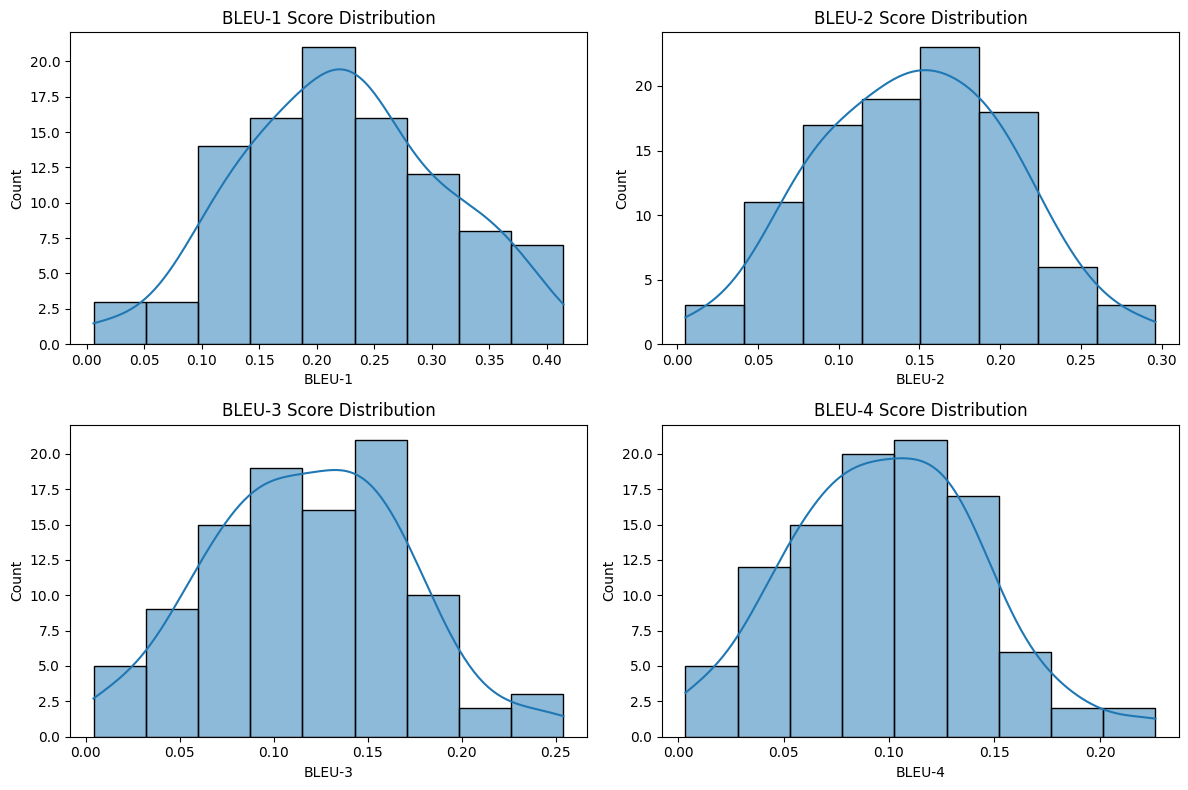

In [ ]:
# wrote plot for Visualize BLEU score distribution
try:
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    sns.histplot(results['bleu-1'], kde=True)
    plt.title('BLEU-1 Score Distribution')
    plt.xlabel('BLEU-1')

    plt.subplot(2, 2, 2)
    sns.histplot(results['bleu-2'], kde=True)
    plt.title('BLEU-2 Score Distribution')
    plt.xlabel('BLEU-2')

    plt.subplot(2, 2, 3)
    sns.histplot(results['bleu-3'], kde=True)
    plt.title('BLEU-3 Score Distribution')
    plt.xlabel('BLEU-3')

    plt.subplot(2, 2, 4)
    sns.histplot(results['bleu-4'], kde=True)
    plt.title('BLEU-4 Score Distribution')
    plt.xlabel('BLEU-4')

    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/model_outputs/bleu_distributions.png")
    plt.show()
except Exception as e:
    print(f"Error creating visualizations: {e}")
    print("Skipping visualizations, but continuing with analysis...")

In [11]:
#analysis
print("\nAnalyzing examples with highest and lowest BLEU scores...")
# Displayed examples with highest BLEU-4 scores
display_examples(results, score_column='bleu-4', n=3, highest=True)

# Displayed examples with lowest BLEU-4 scores
display_examples(results, score_column='bleu-4', n=3, highest=False)


Analyzing examples with highest and lowest BLEU scores...

=== 3 Examples with HIGHEST bleu-4 scores ===

Example 1 - bleu-4: 0.3296
Context: HAWK They lived by and for push buttons and machines, and knew nothing else. But Endicott remembered about the old days--when a man could save a life without a push-button...._ [Transcriber's Note: This etext was produced from Worlds of If Science Fiction, March 1955. 
Input: Extensive research did not uncover any evidence
Reference: Extensive research did not uncover any evidence that the U.S. copyright on this publication was renewed.] When he enters the cargo hold, he finds his way onto the disabled ship. Allison asks him to open the hatch in the side of the hull so they can use the outside airship as an escape hatch. The hatch is big enough for one person to pass through at a time.
Prediction: Extensive research did not uncover any evidence that the U.S. copyright on this publication was renewed.] When he enters the ship, the doctor tells hi

In [12]:
#tf idf metric
print("\nCalculating additional TF-IDF similarity metric...")
try:
    enhanced_results = calculate_tfidf_similarity(results)
    enhanced_results.to_csv("/content/drive/MyDrive/model_outputs/evaluation_results_enhanced.csv", index=False)
    print(f"Enhanced evaluation results saved to /content/drive/MyDrive/model_outputs/evaluation_results_enhanced.csv")
except Exception as e:
    print(f"Error calculating TF-IDF similarity: {e}")
    print("Skipping TF-IDF calculation...")


Calculating additional TF-IDF similarity metric...

Average TF-IDF Cosine Similarity: 0.2491
Enhanced evaluation results saved to /content/drive/MyDrive/model_outputs/evaluation_results_enhanced.csv


In [13]:
# Generated summary report
print("\n" + "="*50)
print("SUMMARY OF MODEL EVALUATION")
print("="*50)
print(f"Model path: {model_path}")
print(f"Number of test examples: {len(results)}")
print(f"Average BLEU-1: {results['bleu-1'].mean():.4f}")
print(f"Average BLEU-2: {results['bleu-2'].mean():.4f}")
print(f"Average BLEU-3: {results['bleu-3'].mean():.4f}")
print(f"Average BLEU-4: {results['bleu-4'].mean():.4f}")
if 'tfidf_similarity' in results.columns:
    print(f"Average TF-IDF Similarity: {results['tfidf_similarity'].mean():.4f}")
print("="*50)
print("All results have been saved to your Google Drive.")
print("="*50)


SUMMARY OF MODEL EVALUATION
Model path: /content/drive/MyDrive/model_outputs/final_model
Number of test examples: 100
Average BLEU-1: 0.3122
Average BLEU-2: 0.1950
Average BLEU-3: 0.1500
Average BLEU-4: 0.1210
Average TF-IDF Similarity: 0.2491
All results have been saved to your Google Drive.
